In [1]:
! pip install ChannelAttribution --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.8/744.8 kB 19.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from ChannelAttribution import markov_model
from tensorflow import keras
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
import sys
from itertools import combinations
from math import factorial

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.7


In [3]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/multi_touch_attribution')

Mounted at /content/drive


# Generating and Exploring Data

In this project we use sythentic data for two main reasons.

First, there are very few publicly available datasets that include multiple channels as well as long sequences of engagements (customer journeys). [This paper](https://arxiv.org/pdf/1808.03737) mentions two available datasets from Miaozhen and Criteo, but I could not access the first dataset, and the second dataset does not include channels. I was also able to find [a dataset](https://github.com/AjNavneet/MultiTouch-Attribution-Marketing-Spend-Optimization) with an unknown origin that satisfied this critera, but due to negligble correlation of conversion with customer journey, predictive modeling was not possible on this dataset. It is likely that this dataset was also synthetically generated and the journeys and labels were generated independently (for example, see [this Databricks notebook](https://notebooks.databricks.com/notebooks/CME/Multi-touch_Attribution/index.html#Multi-touch_Attribution_1.html) that uses this strategy for synthetic data generation for multi-touch attribution).

Second, a synthetic dataset allows us to better evaluate the performance of the attribution models.

For this project, I will use a dataset that I genreated by [this simulator](https://github.com/hkindbom/attribution-modelling/blob/master/Models/Simulator.py), which is based on a Poisson process. It specifies the number of users $N$, a time interval $T$, and a number of channels $K$. Each channel $k$ is shown to each user according to a Poisson process with parameter $\lambda_k$ . Then, with a probability $p$ we get an engagement from customer, and condition on engagement, with probability $p'$ conversion happens. The probabilities $p$ and $p'$ grows each time the channel is shown at a rate $p_k$ and $p'_k$ that represent the influence of the channels. There are also several channel-indepdendent factors that model things such as base probability of engagement and convertion which could be found in the code. As explained [here](https://www.diva-portal.org/smash/get/diva2:1596411/FULLTEXT01.pdf), this process is used to model website traffic and is capable of generatiing synthetic data that "resembles" real data from Swedish insurance company Hedvig. The main values are as follows:

Channel 0: $p_0 = 5 \times p'_0 = 0.055$
      
Channel 1:  $p_1 = 5 \times p'_1 = 0.065$

Channel 2:  $p_2 = 5 \times p'_2 = 0.005$

Channel 3:  $p_3 = 5 \times p'_3 = 0.055$

Channel 4:  $p_4 = 5 \times p'_4 = 0.050$

Channel 5:  $p_5 = 5 \times p'_5 = 0.075$

Channel 6: $p_6 = 5 \times p'_6 = 0.002$.

We let $\lambda_k = 0.0125$ for all $k$.





**A Note on Evaluation**

We define the attribution as the shapley values corresponding to the characteristic function $f(S)$, where for any subset of the channels $S$ is the  the number of conversions when only those channels are present. We estimate Shapely values by simulating the process for any subset of channels. To get these values, I have slightly modified the simulator code. The modified code is included in gen_data.py.


In [6]:
import gen_data

Next, we estimate the number of conversions for any subset of channels by generating samples and calculate the shapely values.

In [7]:
def powerset(n):
  powerset = []
  for i in range(n):
    combination_set = combinations(range(n), i+1)
    for s in combination_set:
      powerset.append({i: k for k, i in enumerate(s)})
  return powerset

In [22]:
n = 7
cohort_size = 20000
sim_time = 300
subset_vals = {}
for i, s in enumerate(powerset(n)):
  sim = gen_data.Simulator(cohort_size, sim_time, s)
  sim.run_simulation()
  data_dict, count_pos, count_neg = sim.get_data_dict_format()
  subset_vals[tuple(s.keys())] = count_pos
  if i % 20 == 0:
    print(f'i = {i}')

i = 0
i = 20
i = 40
i = 60
i = 80
i = 100
i = 120


In [23]:
def get_shapely_vals(subset_vals, n):
  shapely_vals = {}
  for s in subset_vals:
    for i in s:
      s_minus_i = tuple(sorted(list(set(s).difference({i}))))
      shapely_vals[f'{i}'] = shapely_vals.get(i, 0) + (subset_vals[s] - subset_vals[s_minus_i]) * (factorial(len(s)-1))*(factorial(n-len(s)))/ factorial(n)
  return shapely_vals
subset_vals[()] = 0
shapely_vals = get_shapely_vals(subset_vals, n)
shapely_vals

{'0': 182.28571428571428,
 '1': 210.71428571428572,
 '2': 43.57142857142857,
 '3': 179.28571428571428,
 '4': 155.28571428571428,
 '5': 258.57142857142856,
 '6': 36.714285714285715}

As a sanity check, we check that the sum of shapely values is equal to the number of conversions when all channels are present:

In [24]:
(sum(shapely_vals.values()) - subset_vals[tuple(range(n))]) < 0.01

True

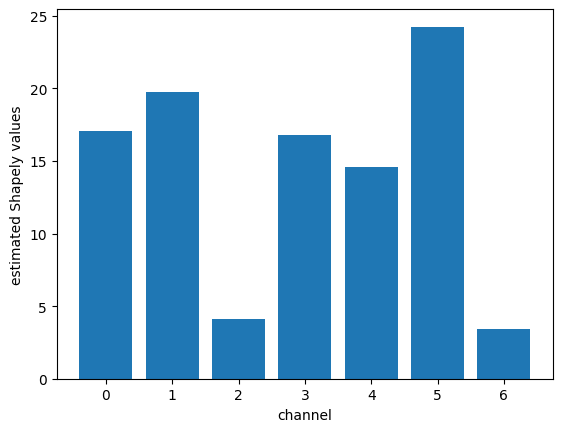

In [25]:
attribution_percentage = {channel: shapely_vals[channel]*100/sum(shapely_vals.values()) for channel in shapely_vals}
plt.bar(attribution_percentage.keys(), attribution_percentage.values())
plt.xlabel('channel')
plt.ylabel('estimated Shapely values')
plt.show()

Now, we generate our training dataset.

In [81]:
num_customers = 100000
sim_time = 300
sim = gen_data.Simulator(num_customers, sim_time, range(n))
sim.run_simulation()
data_dict, count_pos, count_neg = sim.get_data_dict_format(1, None, None)

In [82]:
print(f'pos class size = {count_pos}, neg class size = {count_neg}')

pos class size = 19322, neg class size = 19322


Let's also generate the test set. Note that for the test set, we do not want to downsample the majority class.

In [83]:
num_customers_test = 10000
sim_time = 300
subset_vals = {}
sim = gen_data.Simulator(num_customers_test, sim_time, range(n))
sim.run_simulation()
data_dict_test, count_pos_test, count_neg_test = sim.get_data_dict_format()

In [84]:
print(f'pos class size = {count_pos_test},  neg class size = {count_neg_test}')

pos class size = 1914,  neg class size = 4955


In [85]:
def data_dict_to_df(data_dict):
  df = pd.DataFrame(data_dict).T
  df = df[['journey', 'conversion']]
  journeys = []
  for journey in df.journey:
    journey_str = str(journey[0])
    for channel in journey[1: ]:
      journey_str = journey_str + " " + str(channel)
    journeys.append(journey_str)
  df['journey'] = journeys
  return df


In [86]:
df_train = data_dict_to_df(data_dict)
df_test = data_dict_to_df(data_dict_test)


The following shows the distribution of the length of the customer journey.

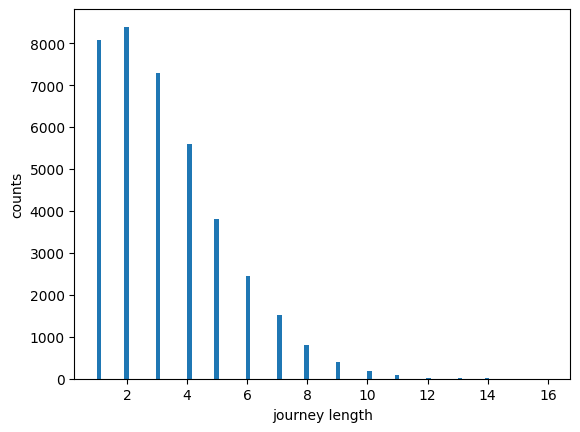

In [87]:
df_train['journey_length'] = df_train.journey.apply(lambda x: len(x.split(" ")))
plt.hist(df_train.journey_length, bins=100)
plt.xlabel('journey length')
plt.ylabel('counts')
plt.show()

Let's also take a look at the distribution of the length of the customer journey condition on the journey leading to conversion.

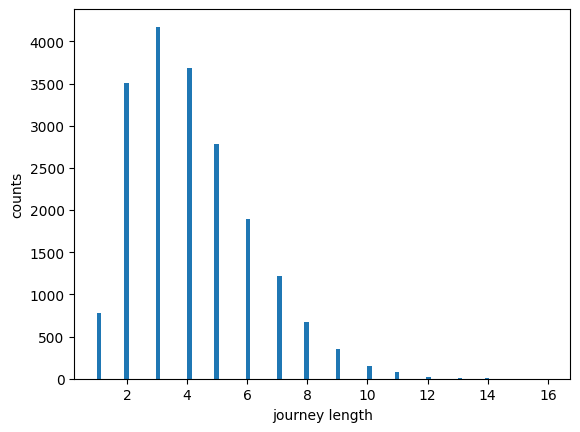

In [88]:
plt.hist(df_train[df_train.conversion==1].journey_length, bins=100)
plt.xlabel('journey length')
plt.ylabel('counts')
plt.show()

# LTA heuristic

The following shows the percentage of attribution of each channel based on the last touch attribution (LTA) heuristic, e.g. all the credit is given to the last channel before conversion.

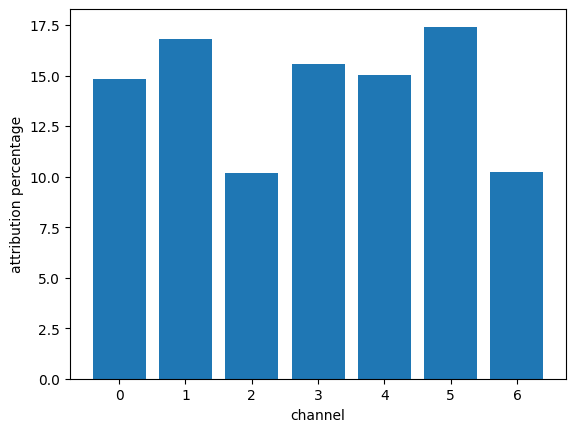

In [89]:
LTA_vals = df_train[df_train.conversion==1]['journey'].apply(lambda x: x.split(" ")[-1]).value_counts()*100/len(df_train[df_train.conversion==1])
LTA_vals = LTA_vals.sort_index()
plt.bar(LTA_vals.index, LTA_vals.values)
plt.xlabel('channel')
plt.ylabel('attribution percentage')
plt.show()

The following is the MSE error of LTA when compared to the estimated shapely values.

In [129]:
def attribution_mse_error(attr_est, attribution_percentage):
  se = 0
  for channel in attr_est:
    se += (attr_est[channel] - attribution_percentage[channel])**2
  return se/len(attr_est)
LTA_shapely_mse_error = attribution_mse_error(LTA_vals.to_dict(), attribution_percentage)
print(f'LTA MSE error = {LTA_shapely_mse_error}')

LTA MSE error = 20.7884051345192


# Methods

We implement an LSTM-based model, as well as a Markov model.

For the LSTM model, the key part of our approach has two components. The first component is an LSTM-based model that, given the sequence of interactions by a customer (customer journey), predicts whether conversion happens or not. The second component is a with a feature attribution method Gradient SHAP that approximates the feature importance for the LSTM model.

While we expect that an attributon method based on predicting conversion via LSTM would generally be more effective than heuristics, one cannot expect an improved performance on very short sequences. For example, for sequences of length 1, last touch attribution is already optimal. Plus, for sequences of short length, we expect to see several samples for each possible journey which allows probablistic models like the Markov model to perform very well.

The Markov model is a probabilistic model that learns a transition probability matrix using the data. Having the transition probability matrix, the model can calculate the change in probability of conversion when any channel is removed by removing the channel from state space. We'll see that for sequences of short length, the vanilla Markov model has a high performance.



# Markov Model

The Markov model uses the given data to learn the transition probability matrix of a Markov chain with channels as its state space (plus three states for start, conversion, and non conversion). Having the transition probability matrix, the model calculates the change in probability of conversion when any channel is removed by removing the channel from state space. The removal effect of each channel is $1 - \frac{\text{probability of conversion with channel}}{\text{probability of conversion without channel}}$.  

[ChannelAttribution](https://github.com/DavideAltomare/ChannelAttribution) is an open source library that has implemeted the vanilla Markov model for attribution. We use this library for this section. We need to first prepare the data.


In [92]:
df_markov = df_train.copy()
df_markov['journey'] = df_train['journey'].apply(lambda x: x.replace(" ", ' > '))

In [93]:
df_markov = df_markov.groupby(['journey', 'journey_length']).agg({'conversion': 'sum'}).reset_index(drop=False)
df_markov.head()

,journey,journey_length,conversion
0,0,1,138
1,0 > 0,2,91
2,0 > 0 > 0,3,16
3,0 > 0 > 0 > 0,4,3
4,0 > 0 > 0 > 0 > 1,5,0


Let's first apply the Markov model to data restricted to short sequences, i.e. learning the transition probability matrix based on short sequences only.

In [132]:
length_threshold = 3
df_markov_short = df_markov[df_markov.journey_length <= length_threshold]

In [133]:
markov_dict = markov_model(df_markov_short, 'journey', 'conversion', out_more=True)
channel_effects_short = markov_dict['removal_effects']
channel_effects_short ['attribution_percentage'] = channel_effects_short['removal_effect']/channel_effects_short['removal_effect'].sum()
channel_effects_short = channel_effects_short.sort_values(by='attribution_percentage', ascending=False)
channel_effects_short

Number of simulations: 100000 - Convergence reached: 1.76% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (4) is reached: 92.53%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,removal_effect,attribution_percentage
5,5,0.421450,0.233013
1,1,0.349806,0.193402
3,3,0.300281,0.166020
0,0,0.289167,0.159876
4,4,0.268235,0.148303
2,2,0.094195,0.052079
6,6,0.085563,0.047307


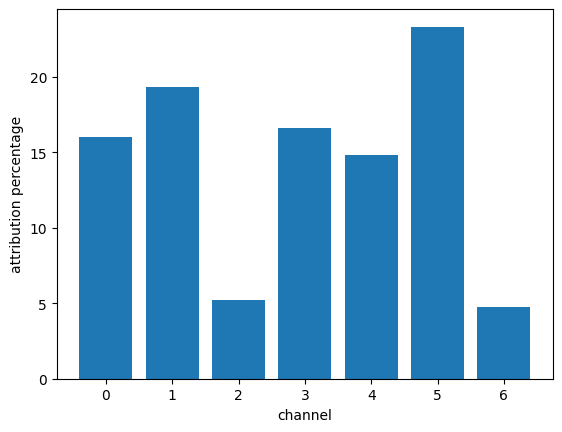

In [134]:
channel_effects_short = channel_effects_short.sort_values(by='channel_name')
plt.bar(channel_effects_short.channel_name, channel_effects_short.attribution_percentage*100)
plt.xlabel('channel')
plt.ylabel('attribution percentage')
plt.show()

For our particular data, attributions should not depend on the length of the sequence. So it makes sense to compare these values to our definitions of real attributions. Note that for this data, applying the markov model on short sequences performs very well. But we are interested in a model that can handle long sequences as well, since in more complicated data, attributions can change for sequences of different length due to the correlation between them (for example a channel might rarely result in conversion if it's the only channel that the customer is exposed to, but significantly increase the probability of conversion in the future if the customer interacts with it.)

In [135]:
markov_short_vals = channel_effects_short[['channel_name', 'attribution_percentage']].set_index('channel_name')['attribution_percentage']*100
markov_short_mse_error = attribution_mse_error(markov_short_vals.to_dict(), attribution_percentage)
print(f'Markov (short) MSE error = {markov_short_mse_error}')

Markov (short) MSE error = 0.7607315133365976


For comparison with LTA, we also apply the Markov model to get attribution of channels for all sequences.

In [99]:
markov_dict = markov_model(df_markov, 'journey', 'conversion', out_more=True)
channel_effects_all = markov_dict['removal_effects']
channel_effects_all ['attribution_percentage'] = channel_effects_all['removal_effect']/channel_effects_all['removal_effect'].sum()
channel_effects_all = channel_effects_all.sort_values(by='attribution_percentage', ascending=False)
channel_effects_all

Number of simulations: 100000 - Convergence reached: 1.11% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (15) is reached: 99.22%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,removal_effect,attribution_percentage
6,5,0.552746,0.197587
2,1,0.494307,0.176697
5,3,0.444736,0.158977
0,0,0.440000,0.157284
1,4,0.414912,0.148316
3,2,0.228715,0.081758
4,6,0.222065,0.079381


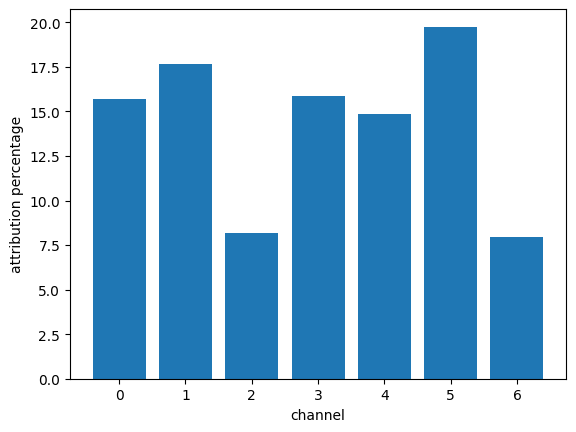

In [100]:
channel_effects_all = channel_effects_all.sort_values(by='channel_name')
plt.bar(channel_effects_all.channel_name, channel_effects_all.attribution_percentage*100)
plt.xlabel('channel')
plt.ylabel('attribution percentage')
plt.show()

In [131]:
markov_vals = channel_effects_all[['channel_name', 'attribution_percentage']].set_index('channel_name')['attribution_percentage']*100
markov_mse_error = attribution_mse_error(markov_vals.to_dict(), attribution_percentage)
print(f'Markov MSE error = {markov_mse_error}')

Markov MSE error = 9.173139756433992


As expected, the Markov model has a high performance on short sequences, but for longer sequences the performance drops.

# LSTM with Gradient SHAP: Preparing Data




As discussed earlier, the first step is a binary classifier for predicting conversion. The features are a sequence of one-hot vectors representing the channel of each touch point. Since the sequences are of variable length, we use padding. So the dimension of the one-hot vectors should be equal to the number of channels plus one.


In [103]:
df_LSTM = df_train.copy()

For longer sequences, there is still data imbalance, but it is less severe (the minority class is about 16%). To handle the data imbalance and prevent the model from prioretizing false negatives, we will use a weighted version of cross entropy loss.

In [107]:
journeys = df_LSTM.journey.to_numpy()
labels = df_LSTM.conversion.to_numpy()
data = np.concatenate([np.expand_dims(journeys, axis=1), np.expand_dims(labels, axis=1)], axis=1)
rng = default_rng()
rng.shuffle(data)
journeys = data[:, :-1]
labels = data[:, -1].astype('int')

Tensorflow has a [TextVectorization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) that can be used easily get a sequence of the integers representing the touch points and use padding and cutting sequence lengths to match their lengths. The output can readily be passed to a PyTorch embedding layer.

In [108]:
seq_length = 16
vocab_size = 10
text_vect_layer = keras.layers.TextVectorization(max_tokens=vocab_size,
                                       standardize=None,
                                       split='whitespace',
                                       output_mode='int',
                                       output_sequence_length=seq_length)
text_vect_layer.adapt(journeys)
journeys_vectorized = layer(journeys).numpy()


In [109]:
vocab_mapping = {channel: i for i, channel in enumerate(layer.get_vocabulary())}

# LSTM with Gradient SHAP: LSTM-Based Predictive Model

In this section, we implement the LSTM-based predictive model.

In [110]:
X = torch.from_numpy(journeys_vectorized)
y = torch.from_numpy(labels)

In [111]:
X_one_hot = torch.nn.functional.one_hot(X).type(torch.float)
X_one_hot.shape

torch.Size([38644, 16, 9])

In [112]:
train_size = 30000
train_data = TensorDataset(X_one_hot[:train_size, :], y[:train_size])
val_data = TensorDataset(X_one_hot[train_size:, :], y[train_size:])

In [113]:
class LSTM_classifier(nn.Module):
  def __init__(self, input_dim, embedding_dim=16, hidden_dim=32, bidirectional=True):
    super().__init__()
    self.embedding = nn.Linear(input_dim, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
    self.linear = nn.Linear(hidden_dim*2, 2)


  def forward(self, x):
    x = self.embedding(x)
    output, _ = self.lstm(x)
    return self.linear(output[:, -1, :])

In [161]:
def train_loop(model, dataloader, loss_fn, optimizer, device):
  model.train()
  for batch_num, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch_num % 100 == 1:
      loss = loss.item()
      print(f'loss: {loss:7f}, batch_num: {batch_num}/{len(dataloader)}')

def eval_loop(model, dataloader, loss_fn, device):
  model.eval()
  loss = 0
  correct = 0
  true_pos = 0
  pos_preds = 0
  real_pos = 0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (torch.argmax(pred, dim=1) == y).type(torch.float).sum().item()
  loss /= len(dataloader)
  correct /= len(dataloader.dataset)
  print(f'loss: {loss:7f}, accuracy: {correct}')

In [115]:
batch_size = 20
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [116]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = LSTM_classifier(input_dim=X_one_hot.shape[-1])
model.to(device)
lr = 0.001
optimzer = Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
epoch = 1
for i in range(epoch):
  print(f'epoch: {i+1}')
  train_loop(model, train_dataloader, loss_fn, optimzer, device)
  eval_loop(model, val_dataloader, loss_fn, device)

epoch: 1
loss: 0.718965, batch_num: 1/1500
loss: 0.697004, batch_num: 101/1500
loss: 0.701884, batch_num: 201/1500
loss: 0.557502, batch_num: 301/1500
loss: 0.485362, batch_num: 401/1500
loss: 0.471663, batch_num: 501/1500
loss: 0.621443, batch_num: 601/1500
loss: 0.692441, batch_num: 701/1500
loss: 0.418956, batch_num: 801/1500
loss: 0.638890, batch_num: 901/1500
loss: 0.647059, batch_num: 1001/1500
loss: 0.627409, batch_num: 1101/1500
loss: 0.464352, batch_num: 1201/1500
loss: 0.600162, batch_num: 1301/1500
loss: 0.421024, batch_num: 1401/1500
loss: 0.558751, accuracy: 0.7027996298010181


In [117]:
model_path = '/content/drive/My Drive/multi_touch_attribution/LSTM.pth'
torch.save(model.state_dict(), model_path)

In [118]:
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

Let's evaluate the predictive model on test data.

In [162]:
journeys_test = df_test.journey.to_numpy()
labels_test = df_test.conversion.to_numpy()
data = np.concatenate([np.expand_dims(journeys_test, axis=1), np.expand_dims(labels_test, axis=1)], axis=1)
rng = default_rng()
rng.shuffle(data)
journeys_test = data[:, :-1]
labels_test = data[:, -1].astype('int')
journeys_vectorized_test = text_vect_layer(journeys_test).numpy()
X_test = torch.from_numpy(journeys_vectorized_test)
y_test = torch.from_numpy(labels_test)
X_one_hot_test = torch.nn.functional.one_hot(X_test).type(torch.float)
test_data = TensorDataset(X_one_hot_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
eval_loop(model, test_dataloader, loss_fn, device)

loss: 0.565745, accuracy: 0.6932595719901005


# LSTM with Gradient SHAP: SHAP Attributions

Finally, for each data point, we estimate the Shapely values of each feature (touch point) using Gradient SHAP. Then, for each channel, we sum up the Shapely values of touch points corresponding to the channel over a random subset of the data (including 1/3 of the dataset for faster computation).

In [119]:
! pip install shap --quiet

In [120]:
import shap

In [121]:
shap_explainer= shap.GradientExplainer(model, X_one_hot)

In [148]:
rand_indx = np.random.choice(train_size, size=10000, replace=False)
shap_vals = shap_explainer.shap_values(X_one_hot[rand_indx, :])

In [149]:
shap_vals = np.maximum(shap_vals[...,1].sum(axis=2), 0)

In [150]:
def split_journey(journey):
  return journey.tolist()[0].split(" ")

def agg_journey_shaps(journey, shap_vals, vocab_size):
  total = np.zeros((vocab_size,))
  for emb, shap_val in zip(split_journey(journey), shap_vals):
    total[int(emb)] += shap_val
  return total

def agg_all_journey_shaps(journeys, shap_vals_list, vocab_size):
  total_total = np.zeros((vocab_size,))
  for journey, shap_vals in zip(journeys, shap_vals_list):
    total = agg_journey_shaps(journey, shap_vals, vocab_size)
    total_total += total
  return total_total

In [151]:
LSTM_vals = agg_all_journey_shaps(np.array(journeys)[rand_indx], shap_vals, vocab_size=n)
LSTM_vals = {f'{i}': LSTM_vals[i]*100/LSTM_vals.sum() for i in range(n)}
LSTM_vals

{'0': 16.331797356514873,
 '1': 22.295775579050765,
 '2': 1.7518187126169156,
 '3': 16.074626923638565,
 '4': 13.677334545633093,
 '5': 26.873890346547427,
 '6': 2.994756535998358}

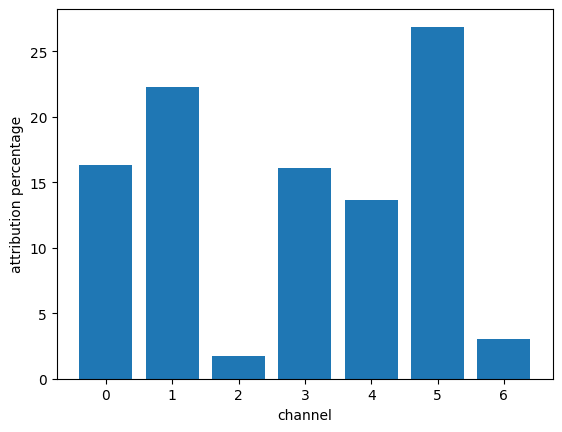

In [5]:
plt.bar(LSTM_vals.keys(), LSTM_vals.values())
plt.xlabel('channel')
plt.ylabel('attribution percentage')
plt.show()

In [152]:
lstm_shapely_mse_error = attribution_mse_error(LSTM_vals, attribution_percentage)
print(f'LSTM MSE error = {lstm_shapely_mse_error}')

LSTM MSE error = 2.9844761767971084


This is a major improvement over LTA (with MSE ~20.8). It is also an improvement over the Markov model applied to all sequences (with MSE ~9.2). For this particular data, applying Markov model to short sequences gives the closest estimate to the (true) Shapely values (with MSE <1). However, as explained earlier, applying the Markov model to short sequences only yeilds good results due to the nature of this synthetic and is not generalizable to datasets where we expect the attribution in short sequences to be different from attribution in long sequences.